In [8]:
import findspark
findspark.init('/opt/spark/spark-3.2.1-bin-hadoop3.2')

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
## Import SparkSession
from pyspark.sql import SparkSession

## Create SparkSession 
spark = SparkSession.builder \
      .master("local") \
      .config("spark.mongodb.input.uri", "mongodb://127.0.0.1") \
      .config("spark.mongodb.output.uri", "mongodb://127.0.0.1") \
      .appName("Spark-MLlib-Titanic") \
      .getOrCreate() 

In [11]:
df = spark.read.format("mongo").option("uri", "mongodb://127.0.0.1/company.Titanic").load()

In [12]:
df = df.drop('_id')

In [13]:
train, test = df.randomSplit([0.8,0.2])

In [14]:
feature = train.columns
feature.remove('Survived')
feature

['Age',
 'Embarked-Rate',
 'Gender-Rate',
 'Pclass',
 'Pclass-Rate',
 'embarkedIndex',
 'is_Family',
 'sexIndex',
 'titleIndex']

In [15]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

In [16]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='Survived', featuresCol='features')

rf = rf.fit(train)

In [17]:
pred = rf.transform(test)

In [18]:
pred.select('Survived', 'prediction', 'probability').show(5)

+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       1|       1.0|[0.42414970125317...|
|       1|       1.0|[0.11515244540295...|
|       1|       1.0|[0.33627019522413...|
|       0|       1.0|[0.46375726860295...|
|       1|       1.0|[0.16515244540295...|
+--------+----------+--------------------+
only showing top 5 rows



In [19]:
pred_pd = pred.select(['Survived', 'prediction', 'probability']).toPandas()
pred_pd

,Survived,prediction,probability
0,1,1.0,"[0.4241497012531701, 0.5758502987468299]"
1,1,1.0,"[0.1151524454029577, 0.8848475545970423]"
2,1,1.0,"[0.3362701952241395, 0.6637298047758605]"
3,0,1.0,"[0.4637572686029561, 0.536242731397044]"
4,1,1.0,"[0.1651524454029577, 0.8348475545970423]"
...,...,...,...
344,0,0.0,"[0.7856662903152031, 0.21433370968479679]"
345,0,0.0,"[0.822440677778381, 0.17755932222161902]"
346,0,0.0,"[0.7825280936384256, 0.21747190636157443]"
347,0,0.0,"[0.8707590655548078, 0.1292409344451922]"


In [20]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_Survived'] = pred_pd['Survived'].map(lambda x: np.eye(2)[int(x)])

In [21]:
# pred_pd[(pred_pd['prediction'] == 0) & (pred_pd['Survived'] == 0)] ## 0 ==> 0
# pred_pd[(pred_pd['prediction'] == 0) & (pred_pd['Survived'] == 1)] ## 0 ==> 1

# pred_pd[(pred_pd['prediction'] == 1) & (pred_pd['Survived'] == 1)] ## 1 ==> 1
# pred_pd[(pred_pd['prediction'] == 1) & (pred_pd['Survived'] == 0)] ## 1 ==> 0

pred_pd.pivot_table(index='prediction', columns='Survived', aggfunc={'prediction':'count'})

prediction    
Survived            0   1
prediction               
0.0               206  47
1.0                10  86

In [22]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_Survived'].tolist())

from sklearn.metrics import auc, roc_curve

fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

print('AUC: {:.3f}'.format(auc))

AUC: 0.881


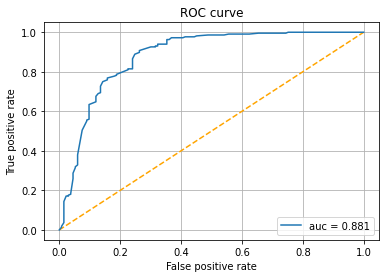

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [25]:
spark.createDataFrame(pred_pd[['Survived','prediction']])\
.write.format("mongo").mode("overwrite")\
    .option("database","company")\
    .option("collection", "TitanicPredict").save()